In [1]:
import numpy as np  # 数値計算ライブラリ（主に配列処理に使用）
import networkx as nx  # グラフ理論処理のためのライブラリ（NetworkX）
import matplotlib.pyplot as plt  # グラフ描画用ライブラリ（Matplotlib）
from sklearn.cluster import (
    KMeans,
)  # クラスタリング手法の一つである KMeans をインポート（scikit-learn）

In [2]:
# サンプル数の設定
n: int = 1000  # 各パターンの点の数
m: int = 50  # ノイズ点の数

# 乱数シードの固定（再現性の確保）
np.random.seed(0)

# ===== 半円弧1の生成（左下） =====
t = np.random.rand(n) * np.pi  # [0, π] の範囲の乱数
x = np.cos(t) - 0.2  # 半円の x 座標を少し左にずらす
y = np.sin(t) - 0.2  # 半円の y 座標を少し下にずらす
a: np.ndarray = np.hstack([x[..., None], y[..., None]])  # 形状を (n, 2) に変換

# ===== 半円弧2の生成（右上） =====
t = np.random.rand(n) * np.pi + np.pi  # [π, 2π] の範囲の乱数（反対側の半円）
x = np.cos(t) + 0.2  # 少し右にずらす
y = np.sin(t) + 0.2  # 少し上にずらす
b: np.ndarray = np.hstack([x[..., None], y[..., None]])  # (n, 2)

# ===== 中心部にノイズを含んだ円形クラスタ（クラスタC） =====
t = np.random.rand(n) * 2 * np.pi  # [0, 2π] の角度
r = np.random.rand(n) * 0.3  # 半径 0~0.3 のランダムな距離
x = r * np.cos(t)
y = r * np.sin(t)
c: np.ndarray = np.hstack([x[..., None], y[..., None]])

# ===== 大きな円周上の点（クラスタD） =====
t = np.random.rand(n) * 2 * np.pi  # [0, 2π]
x = 1.5 * np.cos(t)  # 半径1.5の円
y = 1.5 * np.sin(t)
d: np.ndarray = np.hstack([x[..., None], y[..., None]])

# ===== 均一に分布するノイズ点（クラスタE） =====
e: np.ndarray = np.random.rand(m, 2) * 2 - 1  # [-1, 1] × [-1, 1] の範囲に一様分布

# ===== 全データを統合して少しノイズを加える =====
# a, b, c, e をまとめ、各点に 0~0.1 のノイズを加える
x: np.ndarray = np.concatenate([a, b, c, e]) + np.random.rand(3 * n + m, 2) * 0.1

[]

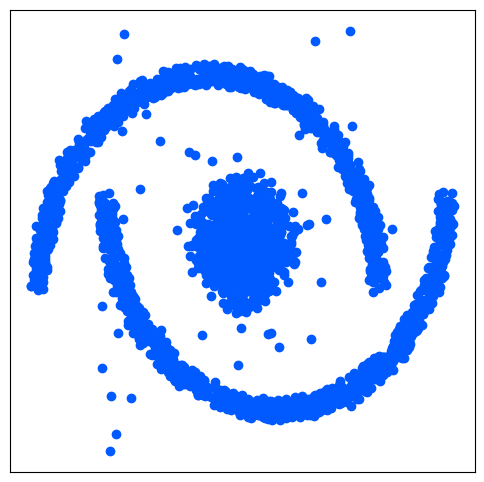

In [3]:
# matplotlib を使って人工データを 2次元平面上に描画する

# 描画領域（Figure, Axes）の作成：6x6インチのサイズ
fig, ax = plt.subplots(figsize=(6, 6))

# 散布図を描画
# x[:, 0]：x座標、x[:, 1]：y座標、c='#005aff'：青色で描画
ax.scatter(x[:, 0], x[:, 1], c="#005aff")

# x軸・y軸の目盛りを非表示にする（見た目をすっきりさせる）
ax.set_xticks([])
ax.set_yticks([])

In [4]:
# KMeansクラスタリングによってデータ x を3つのクラスタに分割する
kmeans = KMeans(
    3, random_state=0, n_init="auto"
)  # クラスタ数: 3, 再現性のため random_state=0, 初期化方法に'n_init="auto"'を使用
kmeans.fit(x)  # データ x に対してクラスタリングを実行
kmeans.labels_.max()  # 割り当てられたクラスタラベルの最大値を取得（2になるはず：ラベルは 0, 1, 2）

2

[]

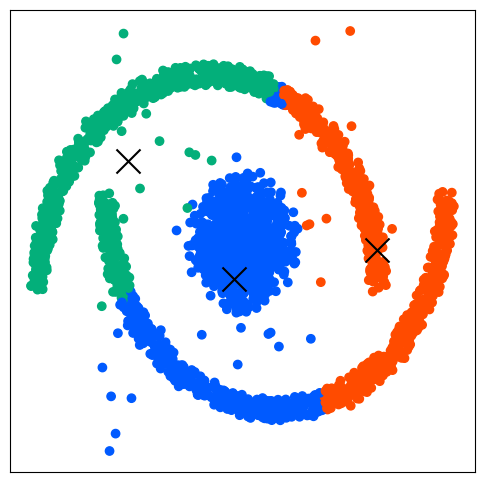

In [5]:
# K-meansクラスタリングの結果を可視化する
# kmeans.labels_ に従って各点に色を割り当てる（0:青, 1:赤, 2:緑）
c = [["#005aff", "#ff4b00", "#03af7a"][c] for c in kmeans.labels_]

# プロット領域の初期化（サイズ 6×6 インチ）
fig, ax = plt.subplots(figsize=(6, 6))

# データ点をクラスタごとの色で散布図として描画
ax.scatter(x[:, 0], x[:, 1], c=c)

# 各クラスタの中心点を黒色の「×」マークで表示（サイズ300）
ax.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c="k",
    marker="x",
    s=300,
)

# 軸目盛りを非表示にする（視覚的にすっきりさせるため）
ax.set_xticks([])
ax.set_yticks([])

In [6]:
# K-NN グラフの構築（K=50）
K = 50

# 全ての点間のユークリッド距離を計算し、距離の昇順にソートされたインデックスを取得
# 各点に対して、最も近い K 個の点のインデックスを取得（ただし自分自身は除くため1:K+1）
edge = np.linalg.norm(x.reshape(1, -1, 2) - x.reshape(-1, 1, 2), axis=2).argsort(
    axis=1
)[:, 1 : K + 1]

# NetworkX グラフオブジェクトの初期化
G = nx.Graph()

# 全ての点をノードとして追加
for i in range(len(x)):
    G.add_node(i)

# 各ノードに対して、K個の近傍ノードとエッジを作成
for i in range(len(x)):
    for j in range(K):
        neighbor = edge[i, j]
        # ノードiとそのK個の近傍ノードにエッジを張る（重み付き）
        # 重みはユークリッド距離に基づいたガウスカーネル（σ^2=0.01）
        dist = np.linalg.norm(x[i] - x[neighbor])
        weight = np.exp(-(dist**2) / 0.01)
        G.add_edge(i, neighbor, weight=weight)

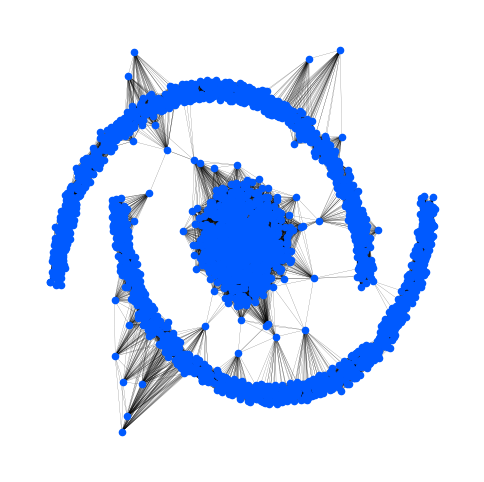

In [7]:
# グラフの図示
fig, ax = plt.subplots(figsize=(6, 6))  # 図のサイズを指定して描画領域を作成

# NetworkX の draw 関数でグラフ G を可視化
# - pos: ノードの座標として、もとの 2 次元データ x を使う
# - node_size: 各ノードのサイズ（20ピクセル）
# - node_color: ノードの色（青系 '#005aff'）
# - width: エッジの線幅（0.1ピクセルで細く描画）
nx.draw(G, ax=ax, pos=x, node_size=20, node_color="#005aff", width=0.1)

In [8]:
# グラフ G のラプラシアン行列を計算し、密行列（numpy形式）に変換して固有分解を行う
# np.linalg.eigh は対称行列用の固有分解（固有値と固有ベクトル）を返す関数
# [1] は固有ベクトルのみを取り出す（[0] を使えば固有値が取れる）
evec: np.ndarray = np.linalg.eigh(nx.laplacian_matrix(G).todense())[1]

[]

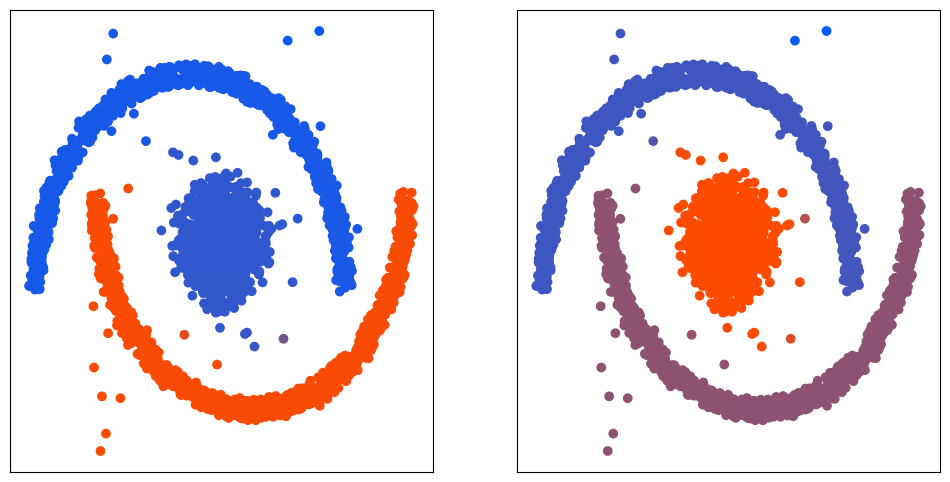

In [9]:
# グラフラプラシアンの第二・第三固有ベクトルを使ってデータを可視化
fig = plt.figure(figsize=(12, 6))  # 図全体のサイズ設定

# --- 第二固有ベクトルによる色付け ---
ax = fig.add_subplot(1, 2, 1)  # 1行2列の1つ目のサブプロット

v = evec[:, 1]  # 第二固有ベクトル（最初の固有ベクトルは定数なので除く）
v = (v - v.min()) / (v.max() - v.min())  # 0〜1 に正規化（色表現のため）

# 色の補間：オレンジ [255, 75, 0]（高値）と青 [0, 90, 255]（低値）の間を線形補間
color = np.array([255, 75, 0]).reshape(3, 1) * v + np.array([0, 90, 255]).reshape(
    3, 1
) * (1 - v)

# 散布図の描画（ノードの位置に色を付けて表示）
ax.scatter(x[:, 0], x[:, 1], c=color.T / 255)  # RGB を 0〜1 に正規化
ax.set_xticks([])  # x軸の目盛りを非表示
ax.set_yticks([])  # y軸の目盛りを非表示

# --- 第三固有ベクトルによる色付け ---
ax = fig.add_subplot(1, 2, 2)  # 2つ目のサブプロット

v = evec[:, 2]  # 第三固有ベクトル
v = (v - v.min()) / (v.max() - v.min())  # 正規化

# 同様に色補間
color = np.array([255, 75, 0]).reshape(3, 1) * v + np.array([0, 90, 255]).reshape(
    3, 1
) * (1 - v)

# 散布図の描画
ax.scatter(x[:, 0], x[:, 1], c=color.T / 255)
ax.set_xticks([])
ax.set_yticks([])

[]

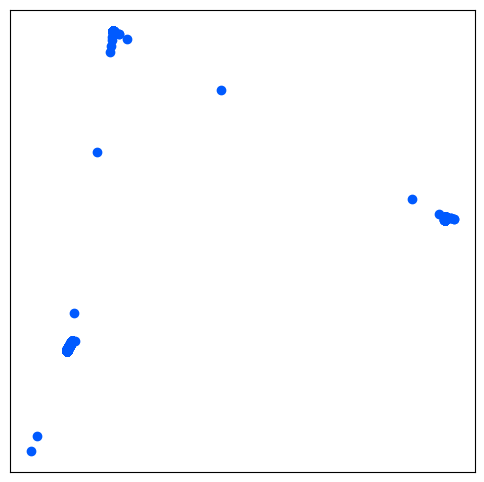

In [10]:
# 固有ベクトル空間上でのデータの可視化（ラプラシアン固有写像による埋め込み）
fig, ax = plt.subplots(figsize=(6, 6))  # 図のサイズを指定してサブプロットを作成

# 第二・第三固有ベクトルを新しい座標軸としてプロット
# → データを低次元（2次元）空間に写像し、クラスタ構造を視覚化
ax.scatter(
    evec[:, 1], evec[:, 2], c="#005aff"
)  # 固有ベクトル(第2, 第3)の成分で散布図を作成
ax.set_xticks([])  # x軸の目盛りを非表示
ax.set_yticks([])  # y軸の目盛りを非表示

[]

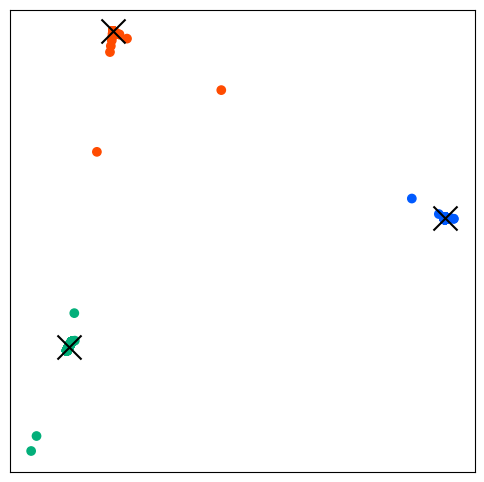

In [11]:
# 固有ベクトル座標系における k-means クラスタリング

# 固有ベクトルの第2・第3成分を用いて k-means クラスタリング（3クラスタ）
kmeans = KMeans(3, random_state=0, n_init="auto")
kmeans.fit(evec[:, 1:3])  # 第2・第3固有ベクトルを特徴量として使用

# 各クラスタに色を割り当て（クラスタラベルごとに色を指定）
c = [["#005aff", "#ff4b00", "#03af7a"][c] for c in kmeans.labels_]

# クラスタリング結果の可視化
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(evec[:, 1], evec[:, 2], c=c)  # データ点を色分けして表示
ax.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c="k",
    marker="x",
    s=300,
)  # クラスタの中心を表示
ax.set_xticks([])  # x軸目盛り非表示
ax.set_yticks([])  # y軸目盛り非表示

[]

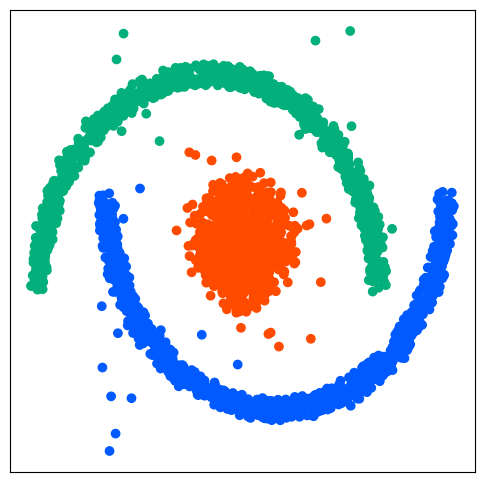

In [12]:
# 元の2次元座標系で、クラスタリング結果を可視化

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x[:, 0], x[:, 1], c=c)  # 各点をクラスタごとの色で表示
ax.set_xticks([])  # x軸の目盛りを非表示にする
ax.set_yticks([])  # y軸の目盛りを非表示にする